In [173]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Reaction parameters
N_MAX = 400  # maximum chain length
k_d = 1e-5   # initiator decomposition rate [1/s]
k_i = 1e3    # initiation rate [L/mol/s]
k_p = 1e3    # propagation rate [L/mol/s]
k_t = 1e7    # termination rate [L/mol/s]
k_tr = 1e0   # chain transfer to monomer [L/mol/s]
f = 0.5      # initiator efficiency

# Initial concentrations [mol/L]
M0 = 5.0     # monomer
I0 = 0.005    # initiator


In [174]:
def polymer_pbe_rhs(t, y):
    dydt = np.zeros_like(y)
    M, I, R = y[0], y[1], y[2]
    P_rad = y[3:3 + N_MAX]
    P_dead = y[3 + N_MAX:]

    # Initiator decomposition
    dI_dt = -k_d * I
    R_gen = 2 * f * k_d * I

    # Initiation
    init = k_i * R * M

    # Propagation
    prop = k_p * P_rad * M

    # Termination matrix --> Only terminatino by combination!!
    term_matrix = np.outer(P_rad, P_rad)
    np.fill_diagonal(term_matrix, 0.5 * np.diag(term_matrix))
    term_rates = k_t * term_matrix
    total_termination = np.sum(term_rates)

    # Chain transfer
    trans = k_tr * P_rad * M

    dydt[0] = -init - np.sum(prop) - np.sum(trans)
    dydt[1] = dI_dt
    dydt[2] = R_gen - init + np.sum(trans)

    for n in range(N_MAX):
        growth = prop[n - 1] if n > 0 else init
        loss = prop[n] + trans[n]
        term_loss = k_t * P_rad[n] * np.sum(P_rad)
        dydt[3 + n] = growth - loss - term_loss
        comb_terms = term_rates[n, :] + term_rates[:, n]
        transfer = trans[n]
        dydt[3 + N_MAX + n] = np.sum(comb_terms) + transfer

    return dydt


In [175]:
def run_simulation(t_end=10000, N_max=N_MAX):
    y0 = np.zeros(3 + 2 * N_max)
    y0[0] = M0
    y0[1] = I0  
    y0[2] = 0

    t_eval = np.linspace(0, t_end, 500)
    sol = solve_ivp(polymer_pbe_rhs, (0, t_end), y0, t_eval=t_eval, method='BDF')
    return sol


In [176]:
def compute_polymer_stats(y):
    P_dead = y[3 + N_MAX:]
    indices = np.arange(1, N_MAX + 1)
    total_polymer = np.sum(P_dead)
    Mn = np.sum(indices * P_dead) / total_polymer if total_polymer > 0 else 0
    Mw = np.sum(indices**2 * P_dead) / np.sum(indices * P_dead) if total_polymer > 0 else 0
    PDI = Mw / Mn if Mn > 0 else 0
    conversion = 1 - y[0] / M0
    return Mn, Mw, PDI, conversion

def plot_chain_length_distribution(y):
    P_dead = y[3 + N_MAX:]
    P_rad = y[3:3 + N_MAX]
    indices = np.arange(1, N_MAX + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(indices, P_dead, label="Dead polymers", linewidth=2)
    plt.plot(indices, P_rad, label="Radical chains", linestyle='--')
    plt.xlabel("Chain length")
    plt.ylabel("Concentration [mol/L]")
    plt.title("Chain Length Distribution at Final Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [177]:
def plot_chain_length_evolution(result, times=[100, 500, 1000, 5000, 10000]):
    indices = np.arange(1, N_MAX + 1)
    time_indices = [np.abs(result.t - t).argmin() for t in times if t <= result.t[-1]]

    plt.figure(figsize=(10, 6))
    for idx in time_indices:
        y = result.y[:, idx]
        P_dead = y[3 + N_MAX:]
        plt.plot(indices, P_dead, label=f"t = {result.t[idx]:.0f} s")

    plt.xlabel("Chain Length")
    plt.ylabel("Concentration [mol/L]")
    plt.title("Evolution of Chain Length Distribution")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show

In [178]:
def plot_conversion_over_time(sol):
    conversions = 1 - sol.y[0, :] / M0
    plt.figure(figsize=(8, 4))
    plt.plot(sol.t, conversions, label="Conversion")
    plt.xlabel("Time [s]")
    plt.ylabel("Conversion")
    plt.title("Conversion vs Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [179]:
def compute_rate_profiles(sol):
    M = sol.y[0, :]
    I = sol.y[1, :]
    R = sol.y[2, :]
    P_rad_all = sol.y[3:3 + N_MAX, :]

    # Radical generation from initiator decomposition
    R_gen = 2 * f * k_d * I

    # Initiation: R· + M → P1·
    initiation = k_i * R * M

    # Propagation: sum over all Pn· + M → Pn+1·
    propagation = np.sum(k_p * P_rad_all * M, axis=0)

    # Termination: approximate total termination as k_t * (∑P_rad)^2
    total_radical = np.sum(P_rad_all, axis=0)
    termination = k_t * total_radical ** 2

    # Chain transfer to monomer: ∑(k_tr * Pn· * M)
    transfer = np.sum(k_tr * P_rad_all * M, axis=0)

    return {
        "time": sol.t,
        "radicals": total_radical,
        "R_gen": R_gen,
        "initiation": initiation,
        "propagation": propagation,
        "termination": termination,
        "transfer": transfer
    }


In [180]:
def plot_reaction_rates(rates):
    plt.figure(figsize=(10, 6))
    plt.plot(rates["time"], rates["radicals"], label="Total Radicals", linewidth=2)
    plt.plot(rates["time"], rates["R_gen"], label="R• Generation", linestyle="--")
    plt.plot(rates["time"], rates["initiation"], label="Initiation", linestyle=":")
    plt.plot(rates["time"], rates["propagation"], label="Propagation", linestyle="-.")
    plt.plot(rates["time"], rates["termination"], label="Termination")
    plt.plot(rates["time"], rates["transfer"], label="Chain Transfer", linestyle="dotted")
    plt.yscale('log')
    plt.xlabel("Time [s]")
    plt.ylabel("Rate [mol/L/s] or Radical Concentration")
    plt.title("Reaction Dynamics Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Final conversion: 0.047
Mn: 187.1, Mw: 257.8, PDI: 1.38


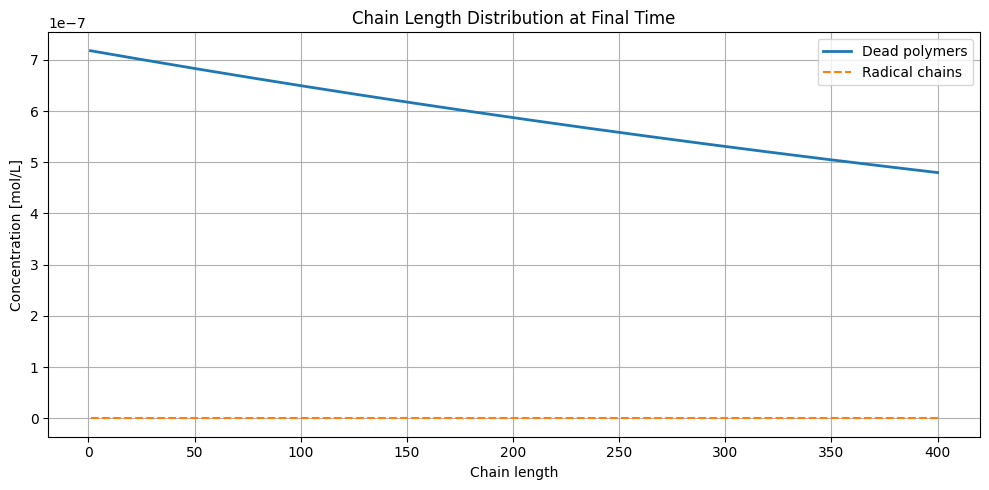

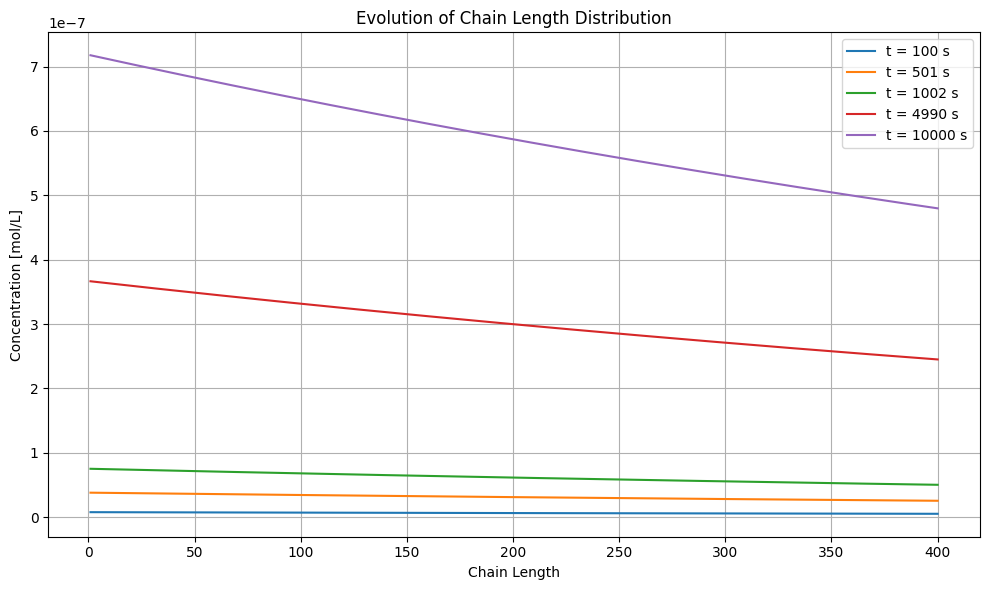

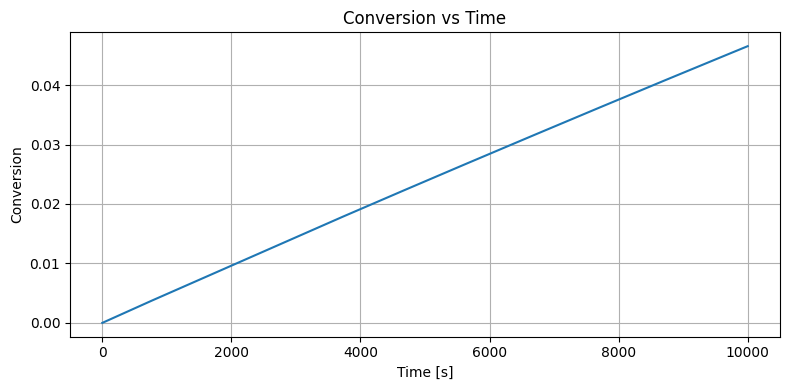

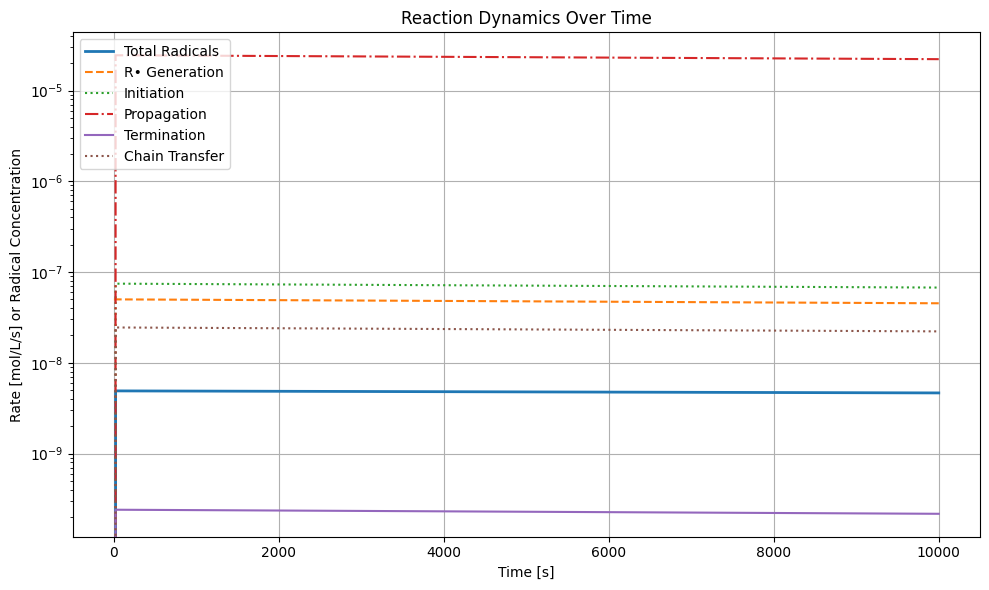

In [181]:
result = run_simulation()
final_state = result.y[:, -1]
Mn, Mw, PDI, conv = compute_polymer_stats(final_state)

print(f"Final conversion: {conv:.3f}")
print(f"Mn: {Mn:.1f}, Mw: {Mw:.1f}, PDI: {PDI:.2f}")

plot_chain_length_distribution(final_state)
plot_chain_length_evolution(result)
plot_conversion_over_time(result)
rates = compute_rate_profiles(result)
plot_reaction_rates(rates)
